# Crystal oscillator

A crystal is a piezo electric device, mechanical forces convert to a voltage and visa versa.

The great thing about crystals is that the mechanical resonance is accurate, relatively independent of environmental conditions, and has a high quality factor.


A common model of the crystal is shown below

<img src="../media/xosc_model.svg"  width="60%" height="60%">


## Am I wrong?

I have a problem with calculating input impedances and transfer functions. I don't trust my own brain when it comes the algebra of expanding symbolic functions. 

In [The Crystal Oscillator](https://ieeexplore.ieee.org/document/7954123) the input impedance is reported as (assuming $R_s = 0$)

$$ Z_{in} \approx \frac{L C_F s^2 + 1}{L C_F C_p s^2 + C_F + C_P}$$

When I compute $Z_{in}$ by hand I got 

$$ Z_{in} = \frac{s^2 C_F L + 1}{s^3 C_P L C_F + s C_P + s C_F}$$

So did I do it wrong? 

## Enter [Sympy](https://docs.sympy.org/latest/index.html)
Python is fantastic, especially the libraries. Imagine that someone has spent their time on making a symbolic library. 

Computers are fantastic at mundane algorithms like algebra. I love to use computers to verify whether I'm right or wrong.

In [1]:
from sympy import symbols,expand,simplify,solve

#- Define the symbols
Gin,Zin, s,Cf,L,Cp,R,Z = symbols("G_{in} Z_{in} s C_F L C_P R Z")

#- Compute impedance
Gin = 1/(R + s*L + 1/(s*Cf)) + s*Cp
Zin = expand(simplify(1/Gin))
Zin

C_F*L*s**2/(C_F*C_P*L*s**3 + C_F*C_P*R*s**2 + C_F*s + C_P*s) + C_F*R*s/(C_F*C_P*L*s**3 + C_F*C_P*R*s**2 + C_F*s + C_P*s) + 1/(C_F*C_P*L*s**3 + C_F*C_P*R*s**2 + C_F*s + C_P*s)

In [2]:
Zin.subs({R:0})

C_F*L*s**2/(C_F*C_P*L*s**3 + C_F*s + C_P*s) + 1/(C_F*C_P*L*s**3 + C_F*s + C_P*s)

Nope, I was right. And probably so was Bezhad. Is my initial setup of the equations wrong?

Next, check the Impedance with some values, for example $C_F = 5$ fF, $C_P = 5$ pF, $L = 50$ mH, and plot the result.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sympy.utilities.lambdify import lambdify

#- Evaluate for some numerical values
Z = Zin.subs({R:50,Cf:5e-15,Cp:5e-12,L:50e-3})

#- Translate to numpy 
f = np.linspace(10.05e6,10.08e6,1000)
w = 1j*2*np.pi*f
func = lambdify(s, Z,'numpy') 
Znum = func(w)

10.070870870870872
-630.6306306308093


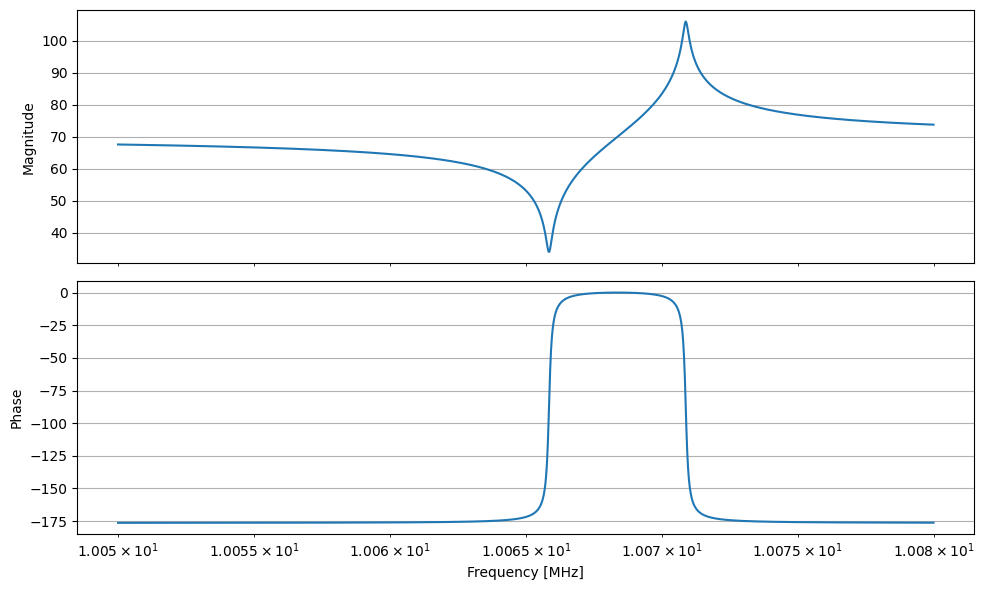

In [36]:
fig, ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
ax[0].semilogx(f*1e-6,20*np.log10(np.abs(Znum)))
ax[0].grid(True)
ax[0].set_ylabel("Magnitude")
ax[1].plot(f*1e-6,(np.angle(Znum) - np.max(np.angle(Znum)))/(np.pi*2)*360)
ax[1].set_xlabel("Frequency [MHz]")
ax[1].set_ylabel("Phase")
ax[1].grid(True)
plt.tight_layout()
plt.savefig("../media/xosc_res.svg")
print(f[np.argmax(np.abs(Znum))]/1e6)
#10.071831831831831
#10.06897897897898 @ 8pF
#10.070870870870872 @ 5pF
print((10.06897897897898  - 10.070870870870872)/3*1e6)

## Discovery

Nope, I did everything right. The reason Bezhad ignores the $1/s$ is that when we look close to the resonance frequencies the impedance of the $1/sCp$ does not change much, as such ignore.